# Neural Network Interpretation

- [Innvestigate](https://github.com/albermax/innvestigate/tree/master?tab=readme-ov-file)

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 17/06/2025   | Martin | Create  | Notebook created. Started on Learned Features | 
| 24/06/2025   | Martin | Update  | Completed Saliency Maps. Started on Detecting Concepts | 
| 27/06/2025   | Martin | Update  | Completed detecting concepts. Finished with section | 

# Content

* [Learned Features](#learned-features)
* [Saliency Maps](#saliency-maps)

# Learned Features

Refer to this [repository](https://github.com/tensorflow/lucid) of explanation examples for learned features.

---

# Saliency Maps

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
IMG_PATH = "./data/sample3.jpg"

# Load image data
orig_image = load_img(IMG_PATH, target_size=(224, 224))
image = img_to_array(orig_image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

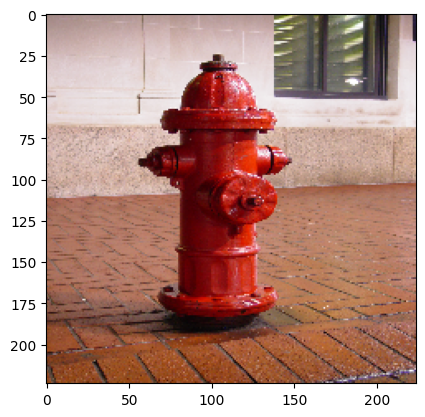

In [4]:

# Plot image
plt.imshow(orig_image)

In [5]:
# Instantiate the model
model = VGG16()

In [6]:
# Make predictions
pred = model.predict(image)
label = decode_predictions(pred)
print(f"Top 5 classes are:")
for i, lab in enumerate(label[0]):
  print(f"{i+1}. {lab[1]} ({round(lab[2], 4)})")

1/1 [==============================] - 0s 161ms/step
Top 5 classes are:
1. milk_can (0.5508000254631042)
2. binoculars (0.19120000302791595)
3. ashcan (0.15960000455379486)
4. cannon (0.026100000366568565)
5. mailbox (0.014600000344216824)


## Vanilla Gradients & DeconvNet

Vanilla Gradients calculate the gradient of the loss function for an interested class wrt. the input pixels (input image). Each element of the final gradient vector represents the sensitivity of the class score to a small change in that feature. The saliency map is then overlaid on the original input image to create a heatmap, indicating areas of "importance" when making predictions

The DeconvNet is an extention to Vanilla Gradients the focus on reconstructing the input pixels using the outcome. It chooses a different backpropagation method.

In [7]:
import innvestigate
import innvestigate.utils
tf.compat.v1.disable_eager_execution()

In [ ]:
model = VGG16()

(-0.5, 223.5, 223.5, -0.5)

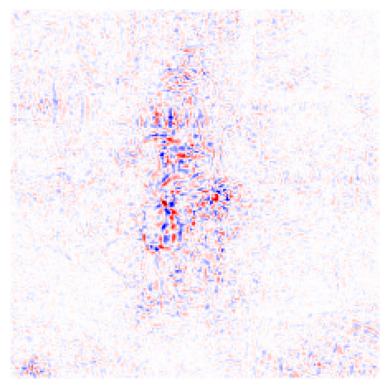

In [15]:
# Vanilla Gradients
# Strip the softmax layer (last layer for logits)
model_no_sm = innvestigate.model_wo_softmax(model)

# Create the analyser
analyser = innvestigate.create_analyzer("gradient", model_no_sm)

# Image and preprocess
x = preprocess_input(image)
a = analyser.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))

# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.axis("off")

d:\Software\venv\py311_env\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(-0.5, 223.5, 223.5, -0.5)

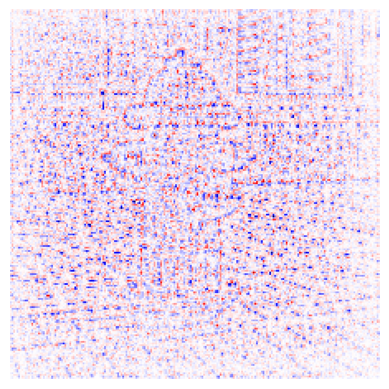

In [14]:
# DeconvNet
analyser = innvestigate.create_analyzer("deconvnet", model_no_sm)
b = analyser.analyze(x)

b = b.sum(axis=np.argmax(np.asarray(b.shape) == 3))
b /= np.max(np.abs(b))

# Plot
plt.imshow(b[0], cmap="seismic", clim=(-1, 1))
plt.axis("off")

## Grad-CAM

Uses gradients of a target class flowing into the final convolutional layer to understand the importance of different spatial regions in the feature map. It averages the importance of each feature map in the final convolutional layer as a weighted sum of feature maps and then measures the positive impact on the target class by the map.

---

# Detecting Concepts

Concepts are any attribute that users are interested in understanding its impact on the prediction. e.g How much does "striped" attribute have in predicting a "zebra"? The method used here is __Testing with Concept Activation Vectors (TCAV)__, it measures the extent that a concept has influence on the model’s prediction for a class.

The method creates a _concept activation vector (CAV)_ that numerically represents the concept in the activation space on a NN layer, and outputs a _concept sensitivity_ score which represents how much of the concept is expressed in the data point (image). The TCAV score is the percentage of images that are well represented by the concept.

Get data from [here](https://github.com/tensorflow/tcav/blob/master/Run_TCAV.ipynb)

📜 NOTE: A tabular version of the TCAV implementation can be found [here](https://github.com/tensorflow/tcav/blob/master/tcav/tcav_examples/discrete/kdd99_discrete_example.ipynb)

In [2]:
%pip install tcav

  Using cached tcav-0.2.2-py3-none-any.whl.metadata (4.4 kB)
Using cached tcav-0.2.2-py3-none-any.whl (54 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

In [3]:
MODEL_TO_RUN = "GoogleNet"
WORKING_DIR = "data/tcav_data"
ACTIVATION_DIR = WORKING_DIR + "/activations/"
CAV_DIR = WORKING_DIR + "/cavs/"
BOTTLENECKS = ['mixed4c']

# Model params
GRAPH_PATH = WORKING_DIR + "/inception5h/tensorflow_inception_graph.pb"
LABEL_PATH = WORKING_DIR + "/inception5h/imagenet_comp_graph_label_strings.txt"
ALPHAS = [0.1]

target = 'zebra'
concepts = ['dotted', 'striped', 'zigzagged']

In [4]:
# Create tensorflow session
sess = utils.create_session()

model = model.GoogleNetWrapper_public(
  sess,
  GRAPH_PATH,
  LABEL_PATH
)

In [5]:
act_generator = act_gen.ImageActivationGenerator(model, WORKING_DIR, ACTIVATION_DIR, max_examples=100)

In [9]:
import absl
absl.logging.set_verbosity(0)
num_random_exp = 4

mytcav = tcav.TCAV(
  sess,
  target,
  concepts,
  BOTTLENECKS,
  act_generator,
  ALPHAS,
  cav_dir=CAV_DIR,
  num_random_exp=num_random_exp
)

print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:mixed4c ['dotted', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed4c ['dotted', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed4c ['dotted', 'random500_2'] zebra 0.1
INFO:tensorflow:mixed4c ['dotted', 'random500_3'] zebra 0.1
INFO:tensorflow:mixed4c ['striped', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed4c ['striped', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed4c ['striped', 'random500_2'] zebra 0.1
INFO:tensorflow:mixed4c ['striped', 'random500_3'] zebra 0.1
INFO:tensorflow:mixed4c ['zigzagged', 'random500_0'] zebra 0.1
INFO:tensorflow:mixed4c ['zigzagged', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed4c ['zigzagged', 'random500_2'] zebra 0.1
INFO:tensorflow:mixed4c ['zigzagged', 'random500_3'] zebra 0.1
INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1
INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1
INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1
INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1
INFO

Class = zebra
  Concept = dotted
    Bottleneck = mixed4c. TCAV Score = 0.79 (+- 0.03), random was 0.49 (+- 0.29). p-val = 0.075 (not significant)
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.89 (+- 0.07), random was 0.49 (+- 0.29). p-val = 0.023 (significant)
  Concept = zigzagged
    Bottleneck = mixed4c. TCAV Score = 0.87 (+- 0.08), random was 0.49 (+- 0.29). p-val = 0.030 (significant)
{'mixed4c': {'bn_vals': [0.01, np.float64(0.8918918918918919), np.float64(0.8716216216216217)], 'bn_stds': [0, np.float64(0.0689056691026052), np.float64(0.08192132197960908)], 'significant': [False, True, True]}}


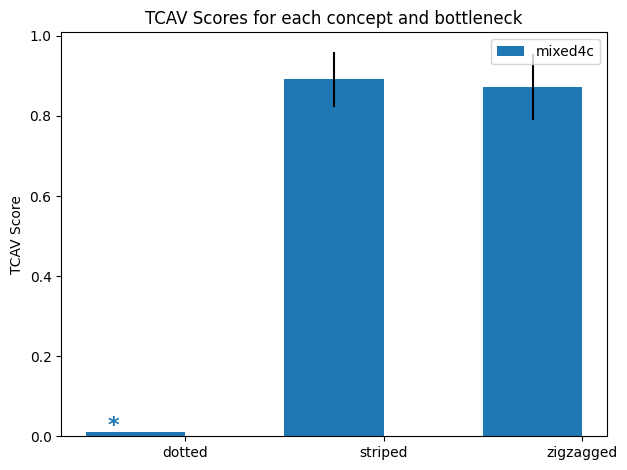

In [10]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)